### Importing the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing





In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data_folder= r'D:\Programming\ML\Datasets\brain tumor MRI images\brain tumor MRI images\Data'


train_path = data_folder + '\\train'
val_path   = data_folder + '\\val'
test_path  = data_folder + '\\test'


print(train_path)
print(val_path)
print(test_path)

D:\Programming\ML\Datasets\brain tumor MRI images\brain tumor MRI images\Data\train
D:\Programming\ML\Datasets\brain tumor MRI images\brain tumor MRI images\Data\val
D:\Programming\ML\Datasets\brain tumor MRI images\brain tumor MRI images\Data\test


In [17]:
IMG_SIZE= (224, 224)

train_data = image_dataset_from_directory(directory= train_path,
                                        image_size= IMG_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)




val_data = image_dataset_from_directory(directory= val_path,
                                        image_size= IMG_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)



test_data = image_dataset_from_directory(directory= test_path,
                                         image_size= IMG_SIZE,
                                         label_mode="categorical",
                                         batch_size=32,
                                         shuffle=False)

Found 14716 files belonging to 3 classes.
Found 828 files belonging to 3 classes.
Found 3682 files belonging to 3 classes.


In [18]:
class_names = train_data.class_names

class_names

['Glioma', 'Meningioma', 'Pituitary tumor']

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

### Transfer learning with VGG16.

In [32]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [33]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
   preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [34]:
inputs = layers.Input(shape=(224 , 224 , 3) , name='Input layer')

x = data_augmentation(inputs)
x =  base_model(x , training = False)
x =  layers.GlobalAveragePooling2D(name= "GlobalAveragePooling2D")(x)

x =  layers.Dense(128,activation='relu')(x)
x =  layers.Dropout(0.2)(x)


x =  layers.Dense(32,activation='relu')(x)
x =  layers.Dropout(0.2)(x)
outputs = layers.Dense(3 , activation='softmax')(x)

model = tf.keras.models.Model(inputs , outputs)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

In [36]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer="adam",
            metrics=['accuracy'])

In [37]:
early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)


checkpoint_path = "checkpoints_weights/checkpoint.ckpt" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, 
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [38]:
import warnings

warnings.filterwarnings('ignore')

initial_epochs = 5

history = model.fit(train_data ,
                validation_data= val_data,
                epochs=initial_epochs,
                callbacks=[early_stop],
                steps_per_epoch=len(train_data),
                validation_steps=len(val_data) ) 

Epoch 1/5
460/460 [==============================] - 874s 2s/step - loss: 0.8379 - accuracy: 0.5984 - val_loss: 0.6132 - val_accuracy: 0.7597
Epoch 2/5
460/460 [==============================] - 672s 1s/step - loss: 0.6885 - accuracy: 0.6852 - val_loss: 0.5947 - val_accuracy: 0.7524
Epoch 3/5
460/460 [==============================] - 612s 1s/step - loss: 0.6398 - accuracy: 0.7100 - val_loss: 0.5656 - val_accuracy: 0.7766
Epoch 4/5
460/460 [==============================] - 612s 1s/step - loss: 0.6205 - accuracy: 0.7135 - val_loss: 0.4980 - val_accuracy: 0.7862
Epoch 5/5
460/460 [==============================] - 541s 1s/step - loss: 0.6124 - accuracy: 0.7202 - val_loss: 0.5306 - val_accuracy: 0.7766


### Transfer learning with fine-tuning:

In [102]:
base_model.trainable = True
for layer in base_model.layers[:12]:
    layer.trainable = False

In [103]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.001,restore_best_weights=True)

cp = tf.keras.callbacks.ModelCheckpoint(filepath="ft_weights/checkpoints/cp-{epoch}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=0)

best = tf.keras.callbacks.ModelCheckpoint(filepath="ft_weights/best/model_best_val_loss.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         save_best_only=True)
fhistory = model.fit(train_data,
                    epochs=history.epoch[-1]+5,
                    validation_data=val_data,
                    initial_epoch=history.epoch[-1],
                    callbacks=[es,cp,best])

model.save('ft_weights/models/vgg16_modified.h5')

Epoch 5/9
460/460 [==============================] - 536s 1s/step - loss: 0.5942 - accuracy: 0.7319 - val_loss: 0.4653 - val_accuracy: 0.7971
Epoch 6/9
460/460 [==============================] - 552s 1s/step - loss: 0.5890 - accuracy: 0.7360 - val_loss: 0.4722 - val_accuracy: 0.7923
Epoch 7/9
460/460 [==============================] - 531s 1s/step - loss: 0.5818 - accuracy: 0.7387 - val_loss: 0.5257 - val_accuracy: 0.7657
Epoch 8/9
460/460 [==============================] - 492s 1s/step - loss: 0.5651 - accuracy: 0.7465 - val_loss: 0.4984 - val_accuracy: 0.7814
Epoch 9/9
460/460 [==============================] - 458s 994ms/step - loss: 0.5638 - accuracy: 0.7441 - val_loss: 0.5556 - val_accuracy: 0.7597


In [40]:
loss = history.history['loss'] + fhistory.history['loss']
val_loss = history.history['val_loss'] + fhistory.history['val_loss']
accuracy = history.history['accuracy'] + fhistory.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fhistory.history['val_accuracy']

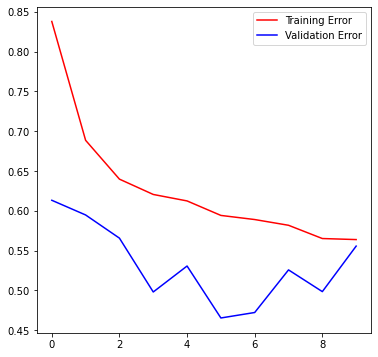

In [41]:
plt.figure(figsize=(6,6))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

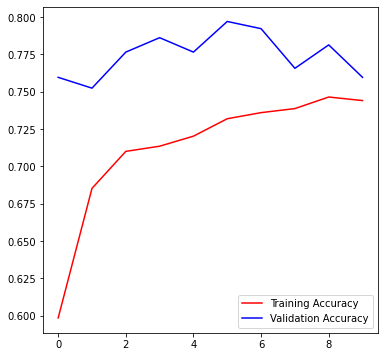

In [42]:
plt.figure(figsize=(6,6))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

In [44]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
print("Loss on test set: {}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy*100))

Loss on test set: 0.5513041019439697
Accuracy on test set: 75.6111%
